## Imports

In [20]:
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import interpolate
from microSWIFTtelemetry import pull_telemetry_as_var
import pickle
import colorcet as cc
from scipy import interpolate

#xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
#plt.imshow(xs, cmap=cc.cm.colorwheel);  # use tab completion to choose



## Getting bouy data

In [21]:



def concatenate_drifters(drifter_dict: dict) -> pd.DataFrame:
    """
    Concatenate a dictionary of individual drifter DataFrames into a single,
    multi-index DataFrame.  Drop the observations that do not contain waves
    (remove off-hour pressure and temperature observations).

    Args:
        drifter_dict (dict): individual drifter DataFrames keyed by id.

    Returns:
        DataFrame: concatenated drifters
    """
    drifter_df = (
        pd.concat(drifter_dict, names=['id', 'time'])
        .dropna(subset='energy_density')
    )
    return drifter_df

DRIFTER_DATA_PATH = './hurricane_idalia_drifter_data_v3.pickle'

with open(DRIFTER_DATA_PATH, 'rb') as handle:
    drifter_data = pickle.load(handle)

# Concatenate the indivudal drifter DataFrames by type
microswift_df = concatenate_drifters(drifter_data['microswift'])
dwsd_df = concatenate_drifters(drifter_data['dwsd'])
spotter_df = concatenate_drifters(drifter_data['spotter'])



# Create a drifter type column
microswift_df['drifter_type'] = 'microswift'
dwsd_df['drifter_type'] = 'dwsd'
spotter_df['drifter_type'] = 'spotter'

# Combine all drifters into a single DataFrame.
drifter_df = (pd.concat([microswift_df, dwsd_df, spotter_df])
              .sort_index(level=['id', 'time'], ascending=True))

drifter_df = drifter_df.loc[drifter_df.latitude >= 27]

#wind data

drifter_wind_variables_df = pd.read_pickle(r'drifter_wind_variables_df.pickle')
drifter_df = drifter_df.join(drifter_wind_variables_df)

#bouy identification

drifterids = drifter_df.index.get_level_values(level="id").unique()

## getting NOAA data

In [22]:
IBTRACS_BASE_URL = ('https://www.ncei.noaa.gov/data/international-best-'
                    'track-archive-for-climate-stewardship-ibtracs/'
                    'v04r00/access/csv/')
IBTRACS_BASE_CSV = f'ibtracs.last3years.list.v04r00.csv'
IBTRACS_PATH = IBTRACS_BASE_URL + IBTRACS_BASE_CSV
ibtracs_df = pd.read_csv(IBTRACS_PATH, low_memory=False)
ibtracs_df = (ibtracs_df
    .query('NAME == "IDALIA"')
    .assign(ISO_TIME = lambda df: pd.to_datetime(df['ISO_TIME'], utc=True))
    .set_index('ISO_TIME', drop=True)
    .assign(LAT = lambda df: df['LAT'].astype(np.float64))
    .assign(LON = lambda df: df['LON'].astype(np.float64))
)


## interpolation station

In [23]:


for drifter in drifterids:
    
    # latitude interpolation
    x = ibtracs_df.index
    y = ibtracs_df['LAT']
    f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
    latxnew = drifter_df.loc[drifter].index #correspond to the microswift times
    latynew = f(pd.to_numeric(latxnew))   # use interpolation function returned by `interp1d`
   
    # Longiutude interpolation
    x = ibtracs_df.index
    y = ibtracs_df['LON']
    f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
    lonxnew = drifter_df.loc[drifter].index #correspond to the microswift times
    lonynew = f(pd.to_numeric(lonxnew))   # use interpolation function returned by `interp1d`
   
    #rmw interpolation
    x = ibtracs_df.index
    y = ibtracs_df['USA_RMW']
    f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
    rmwxnew = drifter_df.loc[drifter].index #correspond to the microswift times
    rmwynew = f(pd.to_numeric(rmwxnew))   # use interpolation function returned by `interp1d`

    # Assign to dataframe
    drifter_df.loc[drifter, 'stormlatitude']=latynew
    drifter_df.loc[drifter, 'stormlongitude']=lonynew
    drifter_df.loc[drifter, 'stormrmwkm']=rmwynew * 1.852
    

## titlehere

In [24]:
def great_circle_pairwise(
    longitude_a: np.ndarray,
    latitude_a: np.ndarray,
    longitude_b: np.ndarray,
    latitude_b: np.ndarray,
    earth_radius: float = 6378.137,
    mod_bearing: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
       # Convert decimal degrees to radians
    longitude_a_rad, latitude_a_rad = map(np.radians, [longitude_a, latitude_a])
    longitude_b_rad, latitude_b_rad = map(np.radians, [longitude_b, latitude_b])

    # Difference longitude and latitude
    longitude_difference = longitude_b_rad - longitude_a_rad
    latitude_difference = latitude_b_rad - latitude_a_rad

    # Haversine formula
    a_1 = np.sin(latitude_difference / 2) ** 2
    a_2 = np.cos(latitude_a_rad)
    a_3 = np.cos(latitude_b_rad)
    a_4 = np.sin(longitude_difference / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a_1 + a_2 * a_3 * a_4))
    distance_km = earth_radius * c

    # True bearing
    bearing_num = np.cos(latitude_b_rad) * np.sin(-longitude_difference)
    bearing_den_1 = np.cos(latitude_a_rad) * np.sin(latitude_b_rad)
    bearing_den_2 = - np.sin(latitude_a_rad) * np.cos(latitude_b_rad) * np.cos(longitude_difference)
    bearing_deg = -np.degrees(np.arctan2(bearing_num, bearing_den_1 + bearing_den_2))

    if mod_bearing:
        bearing_deg = bearing_deg % 360

    return distance_km, bearing_deg


drifter_df['storm_distance'], drifter_df['storm_bearing'] = great_circle_pairwise(
    longitude_a = drifter_df['stormlongitude'],
    latitude_a = drifter_df['stormlatitude'],
    longitude_b = drifter_df['longitude'],
    latitude_b = drifter_df['latitude'],
    earth_radius = 6378.137,
    mod_bearing = True
)


## title

In [25]:

y = np.unwrap(pd.to_numeric(ibtracs_df.STORM_DIR), period=360)
x = ibtracs_df.index
interp_func = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")

for drifter in drifterids:
    xnew = drifter_df.loc[drifter].index
    ynew = interp_func(pd.to_numeric(xnew))
    drifter_df.loc[drifter,'storm_direction'] = ynew % 360

## putting it all in an xy plane

In [26]:
anglefromstormdir = (drifter_df['storm_bearing']-drifter_df['storm_direction'])%360
xstorm = np.sin(anglefromstormdir*np.pi/180)* drifter_df.storm_distance
ystorm = np.cos(anglefromstormdir*np.pi/180)* drifter_df.storm_distance
drifter_df['anglefromstormdir'] = anglefromstormdir
drifter_df['xstorm'] = xstorm
drifter_df['ystorm'] = ystorm

## graphs!

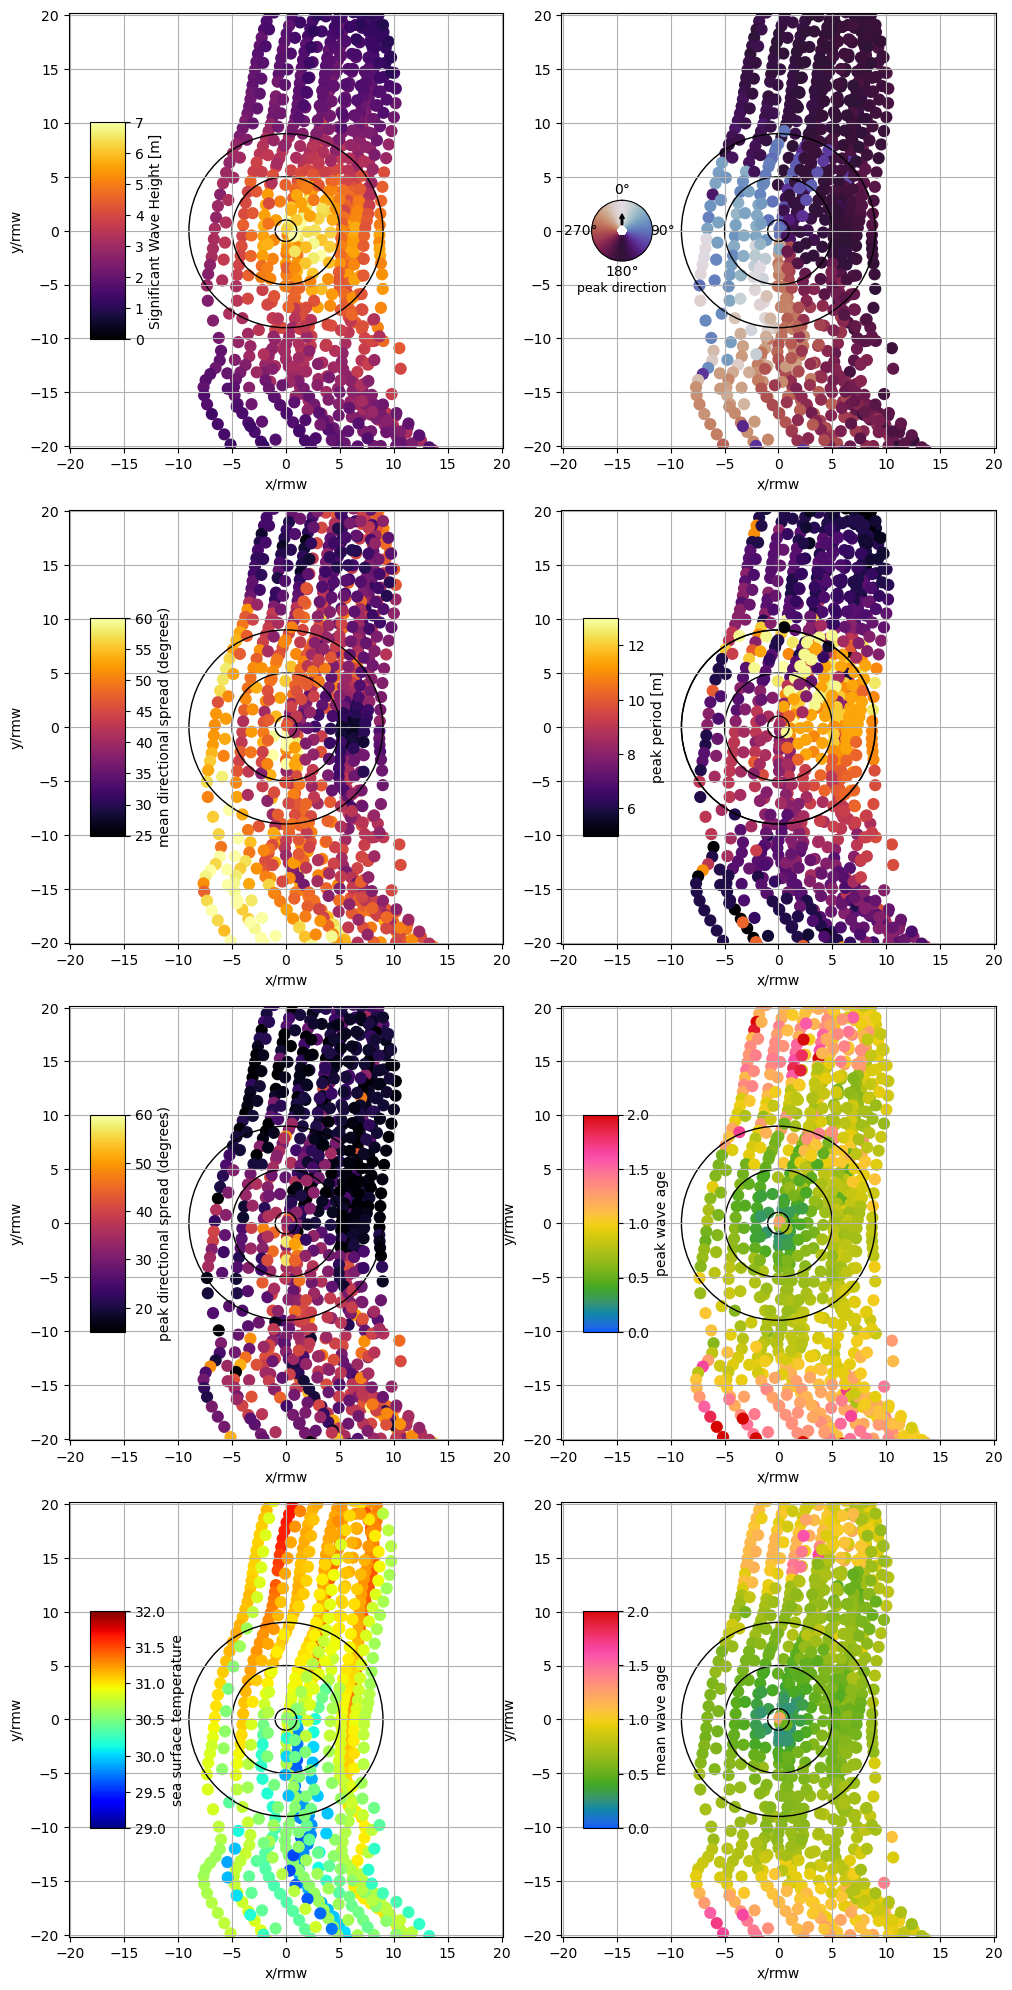

In [30]:

cmap = 'inferno'
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
fig.set_size_inches(10, 20)
fig.tight_layout()


start_date = pd.Timestamp('2023-08-30T00:00', tz='utc')
end_date = pd.Timestamp('2023-08-30T15:00', tz='utc')
time_slice = slice(start_date, end_date)
time_slice_no_tz = slice(start_date.tz_localize(None), end_date.tz_localize(None))
rmwkm = ibtracs_df.loc[time_slice].USA_RMW.apply(float).mean()*1.852

# first plot
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.significant_height
norm = plt.Normalize(0,7)
sc = ax[0,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[0,0].set_xlabel('x/rmw')
ax[0,0].set_ylabel('y/rmw')
ax[0,0].grid()
ax[0,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[0,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0),1, fill=False)
ax[0,0].set_aspect( 1 ) 
ax[0,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0),5, fill=False)
ax[0,0].set_aspect( 1 ) 
ax[0,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[0,0].set_aspect( 1 ) 
ax[0,0].add_patch( cc ) 
ax_cbar = ax[0,0].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='Significant Wave Height [m]')

#graph2
cmap = 'twilight'
plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=c = (drifter_df['peak_direction']-drifter_df['storm_direction'])%360
norm = mpl.colors.Normalize(vmin=0, vmax=360)
sc = ax[0,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[0,1].set_xlabel('x/rmw')
ax[0,1].grid()
circle=plt.Circle((0,0),100)
ax[0,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[0,1].set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[0,1].set_aspect( 1 ) 
ax[0,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[0,1].set_aspect( 1 ) 
ax[0,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[0,1].set_aspect( 1 ) 
ax[0,1].add_patch( cc ) 


legend_location = [0.07, 0.43,.14,.14]  # x, y, width, height
ax2 = ax[0,1].inset_axes(legend_location, projection='polar')
azimuths = np.arange(0, 361, 1)
zeniths = np.linspace(0.2, 1, 10)
values = azimuths * np.ones((len(zeniths), len(azimuths)))
ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmap, norm=norm)
ax2.set_yticks([])
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.xaxis.grid(False)
ax2.tick_params(pad=-3,labelsize=10)
ax2.set_ylim([0, 1])
ax2.set_xticks([0, np.pi/2, np.pi])
ax2.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])

ax3 = ax[0,1].inset_axes(legend_location)
ax2.set_xlabel('peak direction', fontsize=9, labelpad=2)



arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()



#peak period, how fast waves go up and down
cmap = 'inferno'
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.peak_period
norm = plt.Normalize(5,13)
sc = ax[1,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[1,1].set_xlabel('x/rmw')
ax[1,1].grid()
ax[1,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[1,1].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 

ax[1,1].set_aspect( 1 ) 
ax[1,1].add_patch( cc ) 
ax_cbar = ax[1,1].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='peak period [m]')



#mean directional spread
cmap = 'inferno'
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.mean_directional_spread
norm = plt.Normalize(25,60)
sc = ax[1,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[1,0].set_xlabel('x/rmw')
ax[1,0].set_ylabel('y/rmw')
ax[1,0].grid()
ax[1,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[1,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[1,0].set_aspect( 1 ) 
ax[1,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[1,0].set_aspect( 1 ) 
ax[1,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[1,0].set_aspect( 1 ) 
ax[1,0].add_patch( cc ) 
ax_cbar = ax[1,0].inset_axes([0.05, 0.25, 0.08, 0.5])

fig.colorbar(sc, cax=ax_cbar, label='mean directional spread (degrees)')
#peak spread
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.peak_directional_spread
norm = plt.Normalize(15,60)
sc = ax[2,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[2,0].set_xlabel('x/rmw')
ax[2,0].set_ylabel('y/rmw')
ax[2,0].grid()
ax[2,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[2,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[2,0].set_aspect( 1 ) 
ax[2,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[2,0].set_aspect( 1 ) 
ax[2,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[2,0].set_aspect( 1 ) 
ax[2,0].add_patch( cc ) 
ax_cbar = ax[2,0].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='peak directional spread (degrees)')

#peak wave age
cmap = "cet_diverging_rainbow_bgymr_45_85_c67"
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.peak_wave_age
norm = plt.Normalize(0,2)
sc = ax[2,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[2,1].set_xlabel('x/rmw')
ax[2,1].set_ylabel('y/rmw')
ax[2,1].grid()
ax[2,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[2,1].set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[2,1].set_aspect( 1 ) 
ax[2,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[2,1].set_aspect( 1 ) 
ax[2,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[2,1].set_aspect( 1 ) 
ax[2,1].add_patch( cc ) 
ax_cbar = ax[2,1].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc,  cax=ax_cbar, label='peak wave age')

#mean wave age
cmap = "cet_diverging_rainbow_bgymr_45_85_c67"
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.mean_wave_age
norm = plt.Normalize(0,2)
sc = ax[3,1].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[3,1].set_xlabel('x/rmw')
ax[3,1].set_ylabel('y/rmw')
ax[3,1].grid()
ax[3,1].set_xlim(np.array([-400, 400]) / rmwkm)
ax[3,1].set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax[3,1].set_aspect( 1 ) 
ax[3,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax[3,1].set_aspect( 1 ) 
ax[3,1].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[3,1].set_aspect( 1 ) 
ax[3,1].add_patch( cc ) 
ax_cbar = ax[3,1].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc,  cax=ax_cbar, label='mean wave age')

#sea surface temperature
cmap="jet"
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm
c=drifter_df.sea_surface_temperature
norm = plt.Normalize(29,32)
sc = ax[3,0].scatter(x,y,c=c, cmap=cmap, norm=norm, s=60)
ax[3,0].set_xlabel('x/rmw')
ax[3,0].set_ylabel('y/rmw')
ax[3,0].grid()
ax[3,0].set_xlim(np.array([-400, 400]) / rmwkm)
ax[3,0].set_ylim(np.array([-400, 400]) / rmwkm)
cc = mpl.patches.Circle(( 0,0),1, fill=False)
ax[3,0].set_aspect( 1 ) 
ax[3,0].add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0),5, fill=False)
ax[3,0].set_aspect( 1 ) 
ax[3,0].add_patch( cc )

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax[3,0].set_aspect( 1 ) 
ax[3,0].add_patch( cc ) 
ax_cbar = ax[3,0].inset_axes([0.05, 0.25, 0.08, 0.5])
fig.colorbar(sc, cax=ax_cbar, label='sea surface temperature')





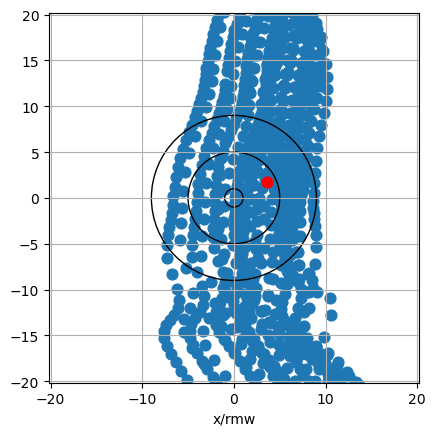

In [34]:
fig, ax = plt.subplots()


plt.grid()
x = drifter_df.xstorm/rmwkm
y = drifter_df.ystorm/rmwkm


sc = ax.scatter(x,y, s=60)
ax.set_xlabel('x/rmw')
ax.grid()
circle=plt.Circle((0,0),100)
ax.set_xlim(np.array([-400, 400]) / rmwkm)
ax.set_ylim(np.array([-400, 400]) / rmwkm)

cc = mpl.patches.Circle(( 0,0), 1, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 5, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 

cc = mpl.patches.Circle(( 0,0), 9, fill=False)
ax.set_aspect( 1 ) 
ax.add_patch( cc ) 





arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])



plt.grid()

drifter_id = '048'
point_start_time = pd.Timestamp('2023-08-30-T06:00', tz='utc')
point_end_time = point_start_time + pd.Timedelta('1h')
drifter_point = drifter_df.loc[drifter_id][point_start_time:point_end_time]
x = drifter_point.xstorm/rmwkm
y = drifter_point.ystorm/rmwkm
norm = plt.Normalize(0,2)
sc = ax.scatter(x,y,color='r', s=60)

plt.show()